<a href="https://colab.research.google.com/github/Valentyn-Oliinyk/N.N.Dog-or-Cat-VGG-model-Introduction/blob/main/N_N_Dog_or_Cat_VGG_model_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Завантажити набір даних із Kaggle.**

In [1]:
!pip install opendatasets

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/dog-vs-cat-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: valentun75
Your Kaggle Key: ··········


100%|██████████| 718M/718M [00:40<00:00, 18.6MB/s]



Extracting archive ./dog-vs-cat-classification/dog-vs-cat-classification.zip to ./dog-vs-cat-classification


**Організувати дані в тренувальний і валідаційний набори.**

In [4]:
split = 0.2
seed = 19453055
batch_size = 256
img_size = (224, 224)

train_ds = keras.utils.image_dataset_from_directory(
    '/content/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training'
)
val_ds = keras.utils.image_dataset_from_directory(
    '/content/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation'
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


**Візуалізувати приклади зображень із тренувального набору з відповідними мітками.**

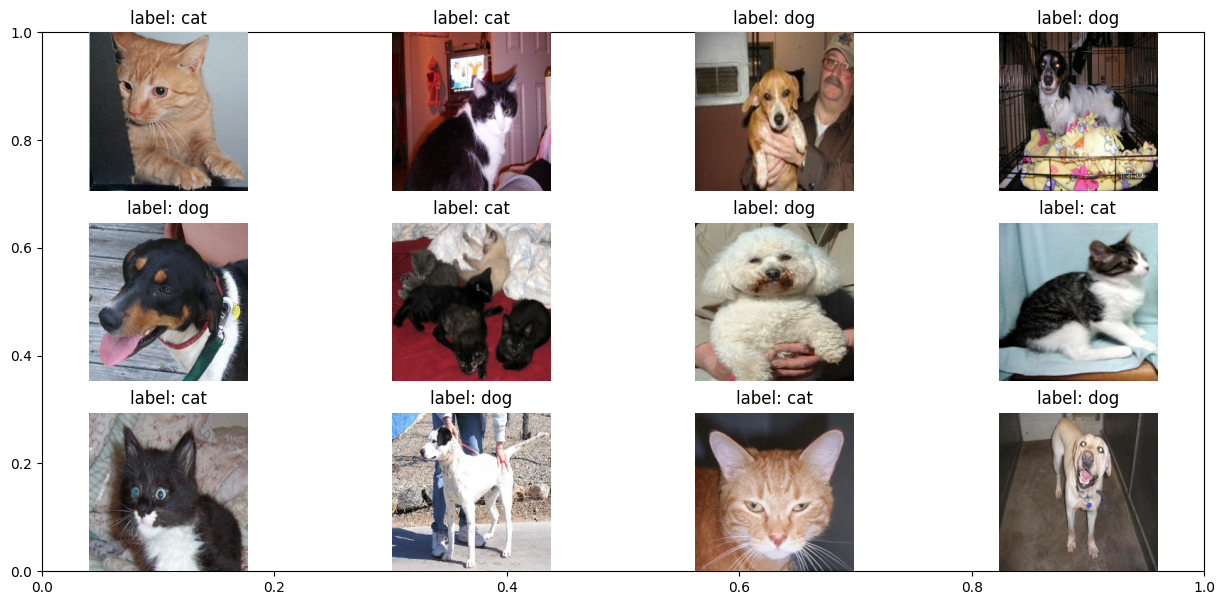

In [5]:
label_names = {0:'cat', 1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(img.numpy()[i]/255)
    plt.axis("off")
    plt.title("label: " + label_names[label.numpy()[i]])
plt.show()

**Побудувати графіки навчання (втрати, точність на тренувальних і валідаційних даних).**

In [6]:
import seaborn as sns

def plot_history(history, title=''):
  if title!='':
    title+=' '
  #Loss
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
  sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax=ax[0])
  sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
  ax[0].legend(loc = 'upper right')
  ax[0].set_title(title+'Loss')
  #Accuracy
  sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
  sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
  ax[1].legend(loc = 'lower right')
  ax[1].set_title(title+'Accuracy')

**Використати data_augmentation для збільшення варіативності тренувальних зображень.**

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.14, 0.14),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2)
    ]
)

**Налаштувати колбеки, такі як ModelCheckpoint і EarlyStopping.**

In [8]:
CB = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    ),

    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=5
    )
]

**Імпортувати базу VGG16 із попередньо навченими вагами.**
**Заморозити базу VGG16.**

In [9]:
vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)

vgg16_base.trainable = False

vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

**Додати власні шари для класифікації.**

In [10]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])
vgg16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 25088)          │        100,352 │ flatten[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 21,439,810 (81.79 MB)

 Trainable params: 6,672,898 (25.46 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

**Навчити модель на тренувальних і валідаційних даних.**

In [12]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=3, # попердньо стояло 100 епох, прибрали оскільки дуже довгий час навчання, а суттєвого покращення немає
    validation_data=val_ds,
    callbacks=CB
)
vgg16_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9653 - loss: 0.0907 - val_accuracy: 0.9842 - val_loss: 0.0453
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9671 - loss: 0.0823 - val_accuracy: 0.9842 - val_loss: 0.0404
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9638 - loss: 0.0933 - val_accuracy: 0.9846 - val_loss: 0.0434


**Візуалізація графіка навчання.**

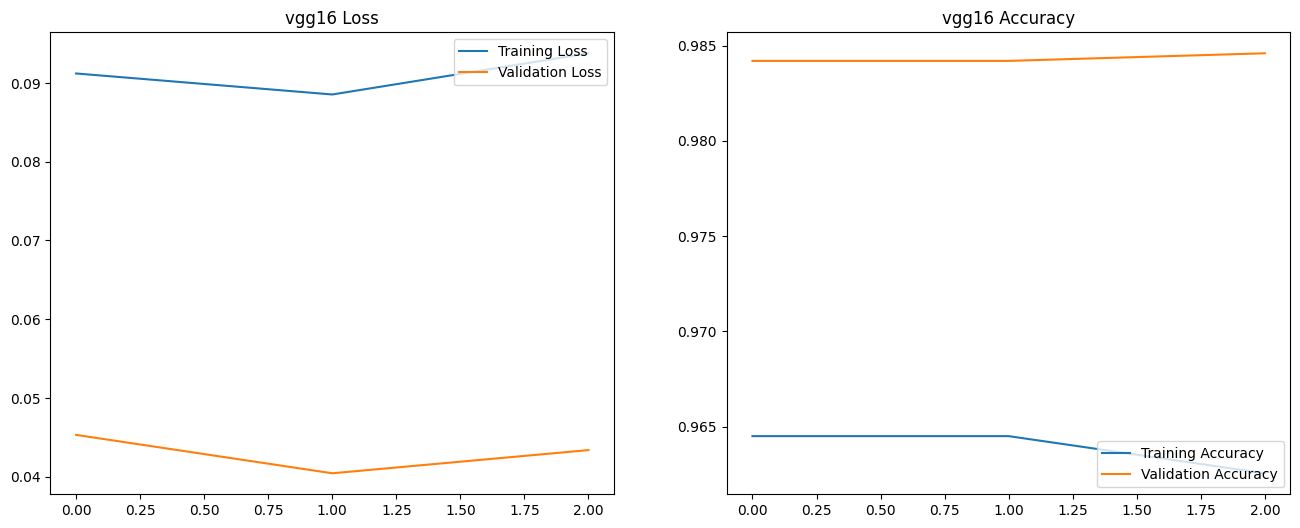

In [13]:
plot_history(history_vgg16, 'vgg16')

**Оцінити модель на валідаційному наборі.**

In [14]:
vgg16_test = vgg16_model.evaluate(val_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9838 - loss: 0.0422


**Організувати дані в тестовому наборі.**

In [15]:
test_ds = keras.utils.image_dataset_from_directory(
    '/content/dog-vs-cat-classification/test/test',
    labels=None,
    label_mode=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # Тестовий набір не перемішується
)


Found 8000 files.


**Провести передбачення на тестових даних і зберегти результати у форматі DataFrame.**

In [16]:
predictions = vgg16_model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


In [18]:
import os
test_filenames = os.listdir("/content/dog-vs-cat-classification/test/test")
results = pd.DataFrame({
    "Filename": test_filenames,
    "Prediction": predicted_classes
})
results["Prediction"] = results["Prediction"].map(label_names)  # Перетворюємо 0/1 на "cat"/"dog"
print(results.head())

     Filename Prediction
0  002998.jpg        dog
1  007377.jpg        dog
2  002195.jpg        dog
3  001643.jpg        cat
4  005713.jpg        dog


**Вивести передбачення моделі на тестових зображеннях із відповідними назвами файлів.**

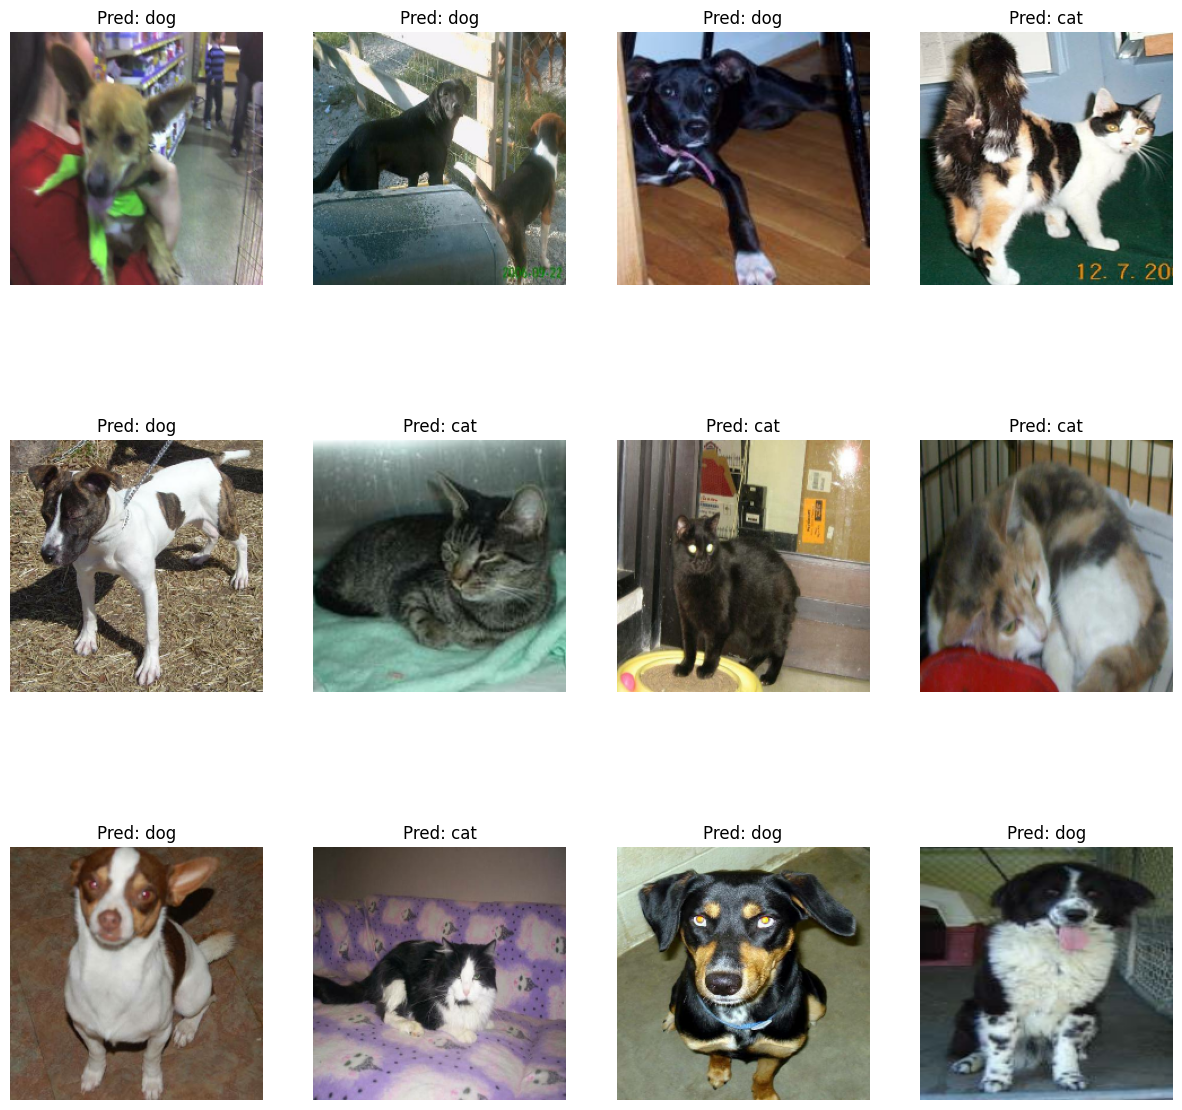

In [19]:
test_filenames = os.listdir("/content/dog-vs-cat-classification/test/test")

# Показуємо кілька зображень із передбаченнями
plt.figure(figsize=(15, 15))
for i, (image, pred) in enumerate(zip(test_ds.unbatch().take(12), predicted_classes[:12])):
    plt.subplot(3, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Pred: {label_names[pred]}")
    plt.axis("off")
plt.show()